# EPFL BIO 322 Project  
### Gene Prediction based on Mouse brain single cell gene expression profiles

### Authors:

- Simon Lee (simon.lee@epfl.ch) 
- Léa Goffinet (lea.goffinet@epfl.ch)

### Project Description

In an experiment on epigenetics and memory, Giulia Santoni (from the lab of Johannes Gr¨aff at
EPFL) measured the gene expression levels in multiple cells of a mouse brain under three different
conditions that we call KAT5, CBP and eGFP. In this challenge, the goal is to predict – as accurately
as possible – for each cell the experimental condition (KAT5, CBP or eGFP) under which it was
measured, given only the gene expression levels.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

from tqdm import tqdm
import requests
import os
import sys
from pathlib import Path
import multiprocessing as mp
from multiprocessing import Process
import concurrent
from multiprocessing import Pool
import xgboost as xgb
import glob

InteractiveShell.ast_node_interactivity = "all"

In [44]:
# read raw data
df = pd.read_csv('../data/train.csv.gz', compression='gzip')
df

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,AC163611.1,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1,labels
0,2.190380,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.293686,CBP
1,2.861984,0.0,0.506726,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506726,KAT5
2,2.766762,0.0,0.629614,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.683511,eGFP
3,2.146434,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.432486,CBP
4,2.840049,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.164235,eGFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.108581,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.312030,KAT5
4996,3.108972,0.0,0.783343,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.518711,eGFP
4997,2.025946,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.025946,CBP
4998,1.227544,0.0,0.791370,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,KAT5


As expected single cell data is extremely sparse. Lets count to see how many non zero entries we actually have per column to get a glimpse of what might be important genes and what might not be important.

In [3]:
gene_column_headers = df.columns.values.tolist()

run this cell only if you want to do filter and write out the counts of how many non zero columns are in each column to a txt file

In [4]:
# # this gets the counts of each column and drops the column accordingly
# f = open('../data/counts.txt', 'w')
# for gene in gene_column_headers:
#     count = (df[gene] != 0).sum()
    
#     f.write('Counts of gene in cells {} : {} \n'.format(gene, count))  # Uncomment if you want to generate text file with counts

#     # new data generator: Takes 3 hrs to run!!
#     # if count < 500:
#     #     df = df.drop(columns=[gene])

# # df.to_csv('../data/filtered_train.csv.gz, compression='gzip')

# f.close()

In [5]:
df_filtered = pd.read_csv('../data/filtered_train.csv.gz')

we can see that the filtering process removed over 22,000 genes that were seen across less than 10% of the cells. Though the threshold is a hyperparameter we believe choosing a smaller hyperparameter will be a safer bet to not throw away useful information

In [6]:
df_filtered

,Unnamed: 0,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,...,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1,labels
0,0,2.190380,0.000000,0.0,0.000000,1.293686,0.000000,1.839343,1.839343,2.190380,...,2.190380,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.293686,CBP
1,1,2.861984,0.506726,0.0,0.000000,0.506726,1.458439,1.291817,1.091771,0.841436,...,0.000000,0.00000,0.000000,0.000000,0.506726,0.000000,0.0,0.000000,0.506726,KAT5
2,2,2.766762,0.629614,0.0,0.000000,1.012971,0.629614,0.629614,0.000000,1.012971,...,0.000000,0.00000,0.000000,0.000000,0.629614,0.000000,0.0,0.000000,1.683511,eGFP
3,3,2.146434,0.000000,0.0,0.000000,0.000000,0.000000,1.060763,0.000000,1.060763,...,0.664895,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.432486,CBP
4,4,2.840049,0.000000,0.0,0.000000,0.000000,1.132100,0.531053,0.000000,1.649491,...,0.531053,0.00000,0.000000,0.000000,0.000000,0.531053,0.0,0.000000,2.164235,eGFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,2.108581,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.644255,0.644255,...,1.312030,0.00000,0.000000,0.000000,1.032877,0.000000,0.0,0.000000,1.312030,KAT5
4996,4996,3.108972,0.783343,0.0,0.000000,0.000000,0.783343,0.783343,0.466491,1.379256,...,0.466491,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.466491,1.518711,eGFP
4997,4997,2.025946,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.386459,0.000000,...,2.650884,0.00000,2.386459,1.456669,1.456669,0.000000,0.0,1.456669,2.025946,CBP
4998,4998,1.227544,0.791370,0.0,0.000000,0.791370,0.000000,0.791370,0.791370,0.791370,...,2.245478,0.79137,1.227544,0.000000,2.108819,0.000000,0.0,0.000000,0.000000,KAT5


In [7]:
df_filtered = df_filtered.drop(columns='Unnamed: 0')

check for any null values incase we need to perform imputation

In [8]:
check_nan = df.isnull().values.any()
print(check_nan)

False


In [9]:
gene_column_headers = df_filtered.columns.values.tolist()

## Method 1 XGBoost

- Once with our filtered data
- Also run with raw data to see if filtering has an effect

In [10]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
# split into train and validation set using sklearn
gene_column_headers_filtered = gene_column_headers[:-1]
y = df_filtered['labels']
X = df_filtered.iloc[:,:-1]

# need to transform our labels from [KAT5, CBP, eGFP] -> [0,1,2] 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [12]:
# perform a typical split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y)

training_data = {'X_train':X_train,'y_train':y_train,
                'X_val': X_val,'y_val':y_val}

In [13]:
X_train.shape

(4000, 9137)

In [14]:
y_train.shape

(4000,)

In [59]:
# fit function where it takes the sklearn and xgboost models and performs the boosted trees.
# plots performance and accuracy as well

def fit(model, training_data=training_data, epochs=300, label_gene = gene_column_headers_filtered):
    # fitting to the sklearn model
    print('Fitting model...')
    model.fit(training_data['X_train'], training_data['y_train'])
    print('Fitting done!')

    # fitting the xboost library model
    train = xgb.DMatrix(training_data['X_train'], label=training_data['y_train'])
    test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
    params = model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    evaluation = {}
    evallist = [(test, 'test'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist, evals_result=evaluation,verbose_eval=100)

    # Model reports
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(model.predict(training_data['X_test']), training_data['y_test'])))
    print('XGBoost F1-Score: '+str(f1_score(model.predict(training_data['X_test']),training_data['y_test'], average='micro')))
    
    # plotting the error curves for our loss functions
    for m in metrics:
        test_score = evaluation['test'][m]
        train_score = evaluation['train'][m]
        x = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(x, test_score, label="Test")
        plt.plot(x, train_score, label="Train")
        
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Epoch')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
    
    # makes sure that the two array match so we can plot the feature importance
    print("length of features list: {}".format(len(gene_column_headers_filtered)))
    print("length of feature importance vector {}".format(len(model.feature_importances_)))

    return xgb_model

Fitting model...
Fitting done!


/Users/simonlee/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	val-mlogloss:1.01506	val-merror:0.23100	train-mlogloss:0.97964	train-merror:0.04325
[100]	val-mlogloss:0.33261	val-merror:0.14700	train-mlogloss:0.00665	train-merror:0.00000
[200]	val-mlogloss:0.31876	val-merror:0.13900	train-mlogloss:0.00232	train-merror:0.00000
[299]	val-mlogloss:0.31241	val-merror:0.13400	train-mlogloss:0.00146	train-merror:0.00000
-- Model Report --
XGBoost Accuracy: 0.866
XGBoost F1-Score: 0.866


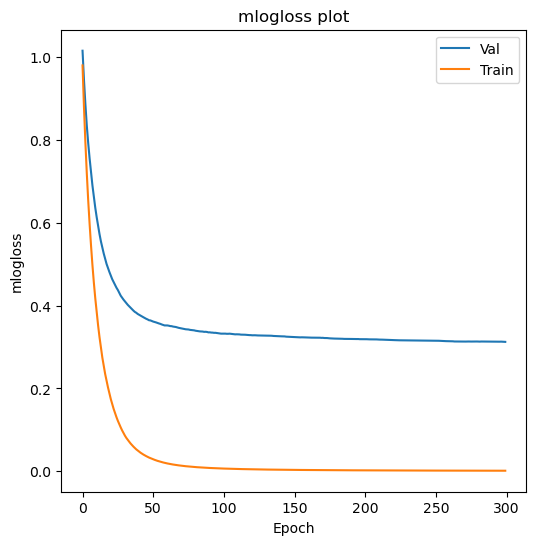

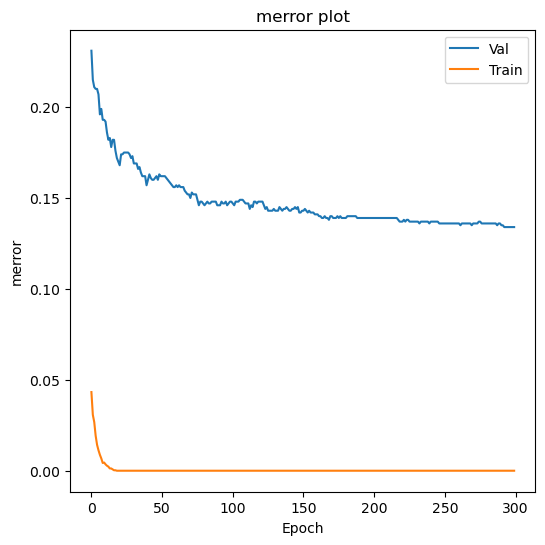

length of features list: 9137
length of feature importance vector 9137


In [16]:
# hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=9, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

read in test.csv.gz to assess model and predictions

In [31]:
test = pd.read_csv('../data/test.csv.gz', compression='gzip', usecols=gene_column_headers_filtered)
test

,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,Gm26901,...,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1
0,3.160117,0.683829,0.0,0.000000,0.000000,0.000000,0.000000,1.086169,0.000000,0.000000,...,0.683829,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.683829,1.086169
1,2.145334,0.000000,0.0,0.000000,0.919876,0.000000,0.562178,1.390774,1.562859,0.562178,...,1.562859,2.307958,0.000000,2.145334,0.562178,0.562178,0.0,0.000000,0.000000,2.570459
2,1.871887,0.000000,0.0,0.000000,0.000000,1.540524,1.041519,1.041519,0.000000,0.000000,...,1.041519,2.120352,0.000000,1.540524,1.041519,2.120352,0.0,0.000000,0.000000,2.319205
3,2.090093,0.882582,0.0,0.535655,0.000000,0.000000,1.139658,0.882582,0.535655,0.000000,...,1.343978,1.343978,0.535655,0.882582,0.000000,0.882582,0.0,0.000000,0.535655,1.513551
4,2.180879,0.000000,0.0,0.000000,0.627369,0.627369,0.627369,1.502010,1.009910,0.000000,...,0.000000,1.009910,0.000000,0.000000,0.627369,0.000000,0.0,0.000000,0.627369,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,0.000000,0.000000,0.0,0.000000,0.000000,1.839566,0.000000,0.000000,0.000000,0.000000,...,2.826214,3.098976,1.839566,2.449937,1.839566,1.839566,0.0,0.000000,1.839566,3.884534
3089,2.622857,0.000000,0.0,0.000000,0.883539,1.345184,0.883539,1.514823,1.140768,0.536331,...,0.000000,1.345184,0.000000,0.000000,0.000000,0.000000,0.0,0.536331,0.536331,1.514823
3090,2.091833,1.020628,0.0,0.000000,0.000000,1.020628,1.515100,0.000000,1.020628,0.000000,...,0.000000,1.020628,0.000000,0.000000,0.000000,1.020628,0.0,0.000000,0.000000,2.721263
3091,2.946953,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.917884,0.917884,0.000000,...,1.948185,0.000000,0.000000,0.000000,0.917884,0.000000,0.0,0.000000,0.000000,1.706920


In [32]:
# get it into dmatrix again
X = test
testing_data = xgb.DMatrix(data=X)

In [36]:
test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
pred = xgb_trained.predict(test)

In [37]:
print(classification_report(training_data['y_val'], pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       370
           1       0.84      0.71      0.77       311
           2       0.99      0.98      0.98       319

    accuracy                           0.87      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.87      0.86      1000



In [41]:
confusion_matrix = confusion_matrix(training_data['y_val'], pred)

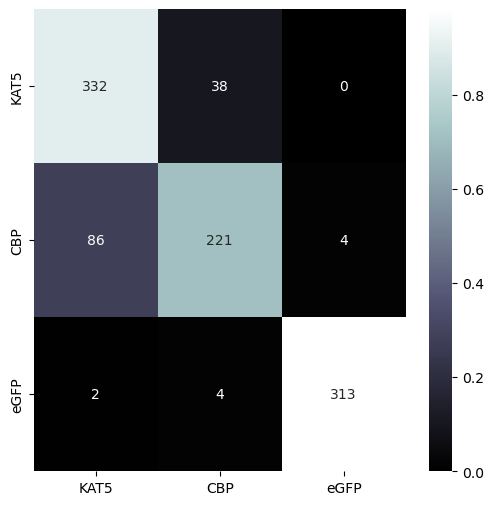

In [42]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
# confusion matrix
plot_confusion_matrix(confusion_matrix, ['KAT5', 'CBP', 'eGFP'])

<AxesSubplot:>

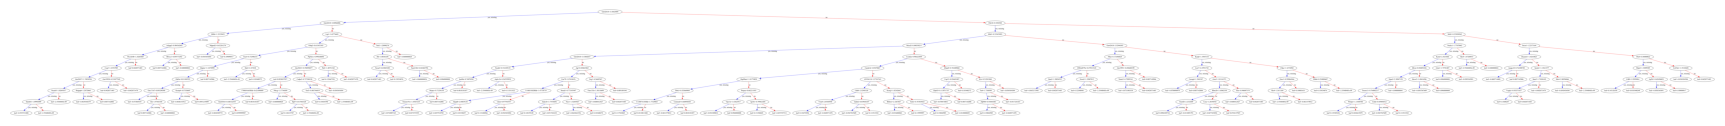

In [72]:
import graphviz
plt.rcParams["figure.figsize"] = [22,40]
xgb.plot_tree(xgb_trained)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

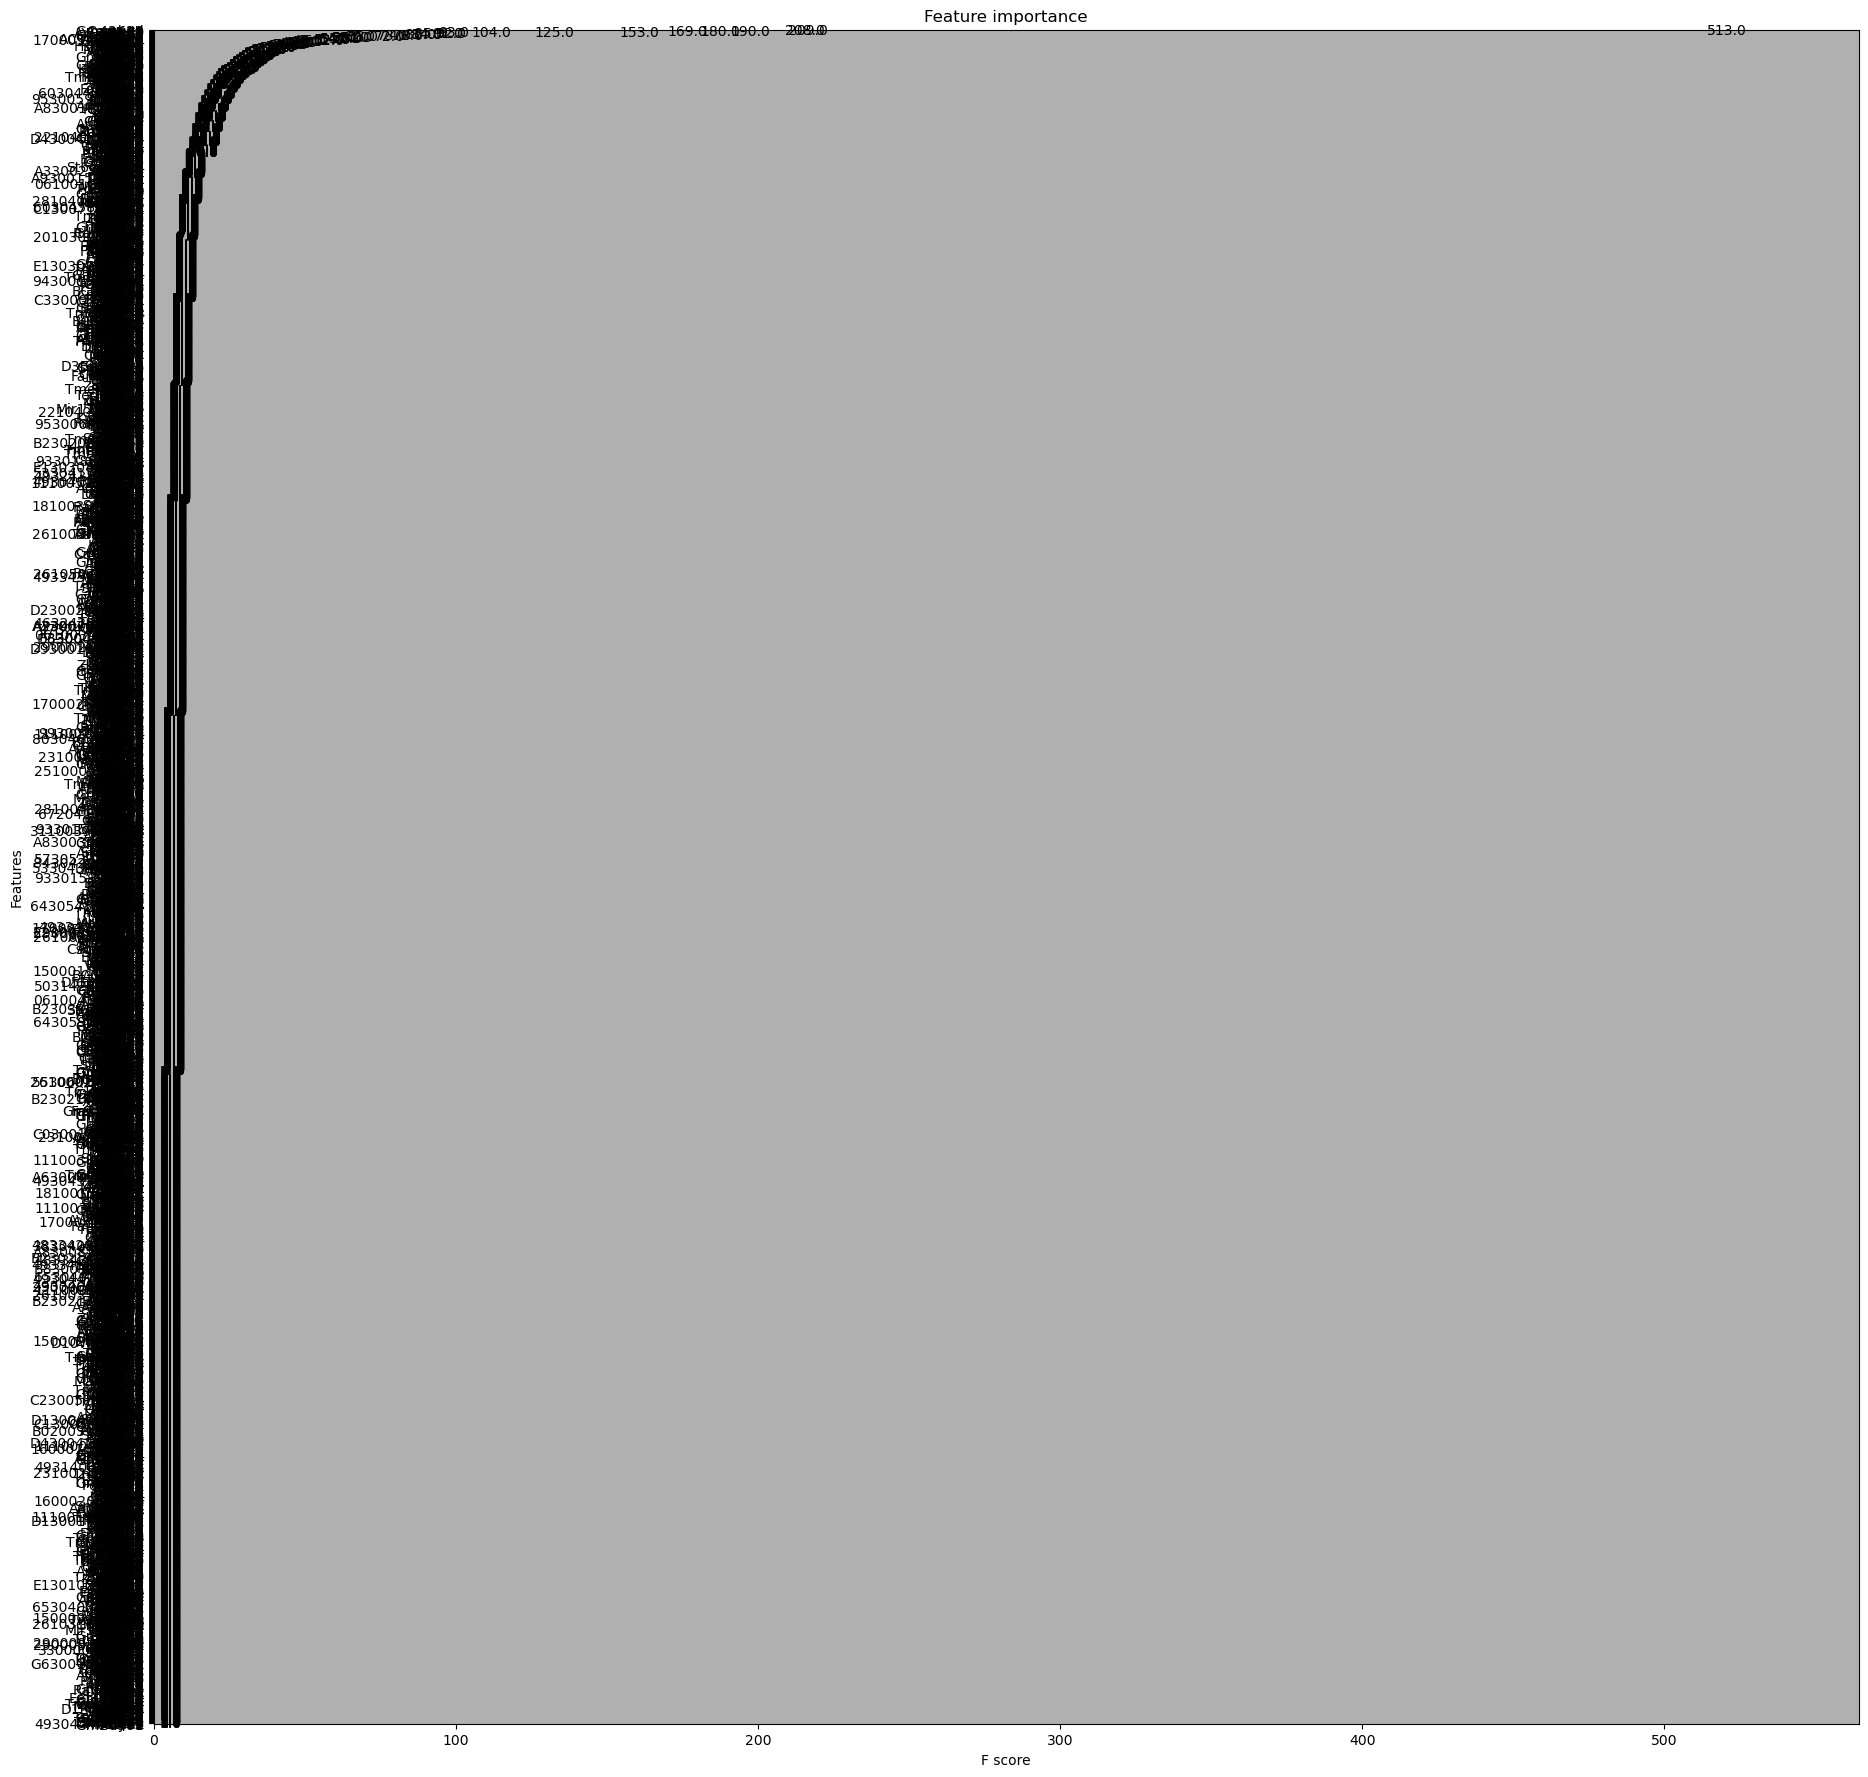

In [70]:
plt.rcParams["figure.figsize"] = [22,22]
xgb.plot_importance(xgb_trained)

In [ ]:
# hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=9, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

as expected alot of features aren't very important but lets still try running our classifier with our raw data 

Raw data. Assess performance

In [52]:
# split into train and validation set using sklearn
y = df['labels']
X = df.loc[:, df.columns != 'labels'] 

# need to transform our labels from [KAT5, CBP, eGFP] -> [0,1,2] 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [53]:
# perform a typical split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

data = {'X_train':X_train,'y_train':y_train,
                'X_test': X_val,'y_test':y_val}

In [54]:
X_train.shape

(4000, 32285)

In [55]:
y_train.shape

(4000,)

In [61]:
# hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=9, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

train more different hyperparameter models

In [ ]:
test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
pred = xgb_trained.predict(test)

In [ ]:
print(classification_report(training_data['y_test'], pred))

In [ ]:
confusion_matrix = confusion_matrix(training_data['y_test'], pred)

In [ ]:
plot_confusion_matrix(confusion_matrix, ['KAT5', 'CBP', 'eGFP'])

## Method 2: Sparse-Input Neural Networks

- Once with our filtered data
- Also run with raw data to see if filtering has an effect